# CEX Market Analysis

Import dependencies

In [1]:
import pandas as pd
from pathlib import Path
import sys
parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))
from utils.general import check_missing_timestamps
import numpy as np
import ccxt
import os 
import matplotlib.pyplot as plt

In [ ]:
def get_exchange_timeframes(exchange_id):
    """
    Get the list of available timeframes for a given exchange.

    Args:
        exchange_id (str): The exchange ID (e.g., "binance", "bitget").

    Returns:
        list: A list of available timeframes for the exchange.
    """
    try:
        # Initialize the exchange
        exchange = getattr(ccxt, exchange_id)({'enableRateLimit': True})

        # Check if the exchange supports timeframes
        if hasattr(exchange, 'timeframes') and exchange.timeframes:
            return list(exchange.timeframes.keys())
        else:
            return []
    except Exception as e:
        print(f"Error fetching timeframes for {exchange_id}: {e}")
        return []

# Example Usage
EXCHANGE_ID = "bitget"  # Replace with your desired exchange ID
timeframes = get_exchange_timeframes(EXCHANGE_ID)
print(f"Available timeframes for {EXCHANGE_ID}: {timeframes}")

In [3]:
PATH = "/home/ubuntu/project/finance/cex-market-analysis/src/data/bitget/future"
TIMEFRAME = "1m"
# Define the folder path
results_folder = "results"

# Create the folder if it doesn't exist
os.makedirs(results_folder, exist_ok=True)

In [ ]:
df = pd.read_csv("/home/ubuntu/project/finance/cex-market-analysis/src/data/bitget/future/BTC_USDT:USDT_1m.csv", header=None)
df = pd.DataFrame(df.values, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
df['date'] = pd.to_datetime(df['date'], unit='ms')
missing = check_missing_timestamps(df, freq='1min')
df.set_index('date', inplace=True)

df = df.resample('1d').agg({
    'open': 'first',     # First price in the 1-hour window (Open)
    'high': 'max',       # Maximum price in the 1-hour window (High)
    'low': 'min',        # Minimum price in the 1-hour window (Low)
    'close': 'last',     # Last price in the 1-hour window (Close)
    'volume': 'sum'      # Total volume in the 1-hour window
})

import plotly.graph_objects as go
# Create a candlestick chart using Plotly
fig = go.Figure(data=[go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    increasing_line_color='green',  # Green for price increase
    decreasing_line_color='red',    # Red for price decrease
)])
# Customize layout
fig.update_layout(
    title='',
    xaxis_title='Date',
    yaxis_title='Price (USDT)',
    template='plotly_dark',  # Set a dark theme for the plot
    xaxis_rangeslider_visible=False  # Optionally hide the range slider
)

In [5]:
## Get Top 100 Future Volume Market
import pandas as pd 

df_volume = pd.read_csv("/home/ubuntu/project/finance/cex-market-analysis/symbols/top_100_bitget.csv",index_col=0)

duration_days= []

for i in range(len(df_volume)):

    symbol = df_volume["symbol"][i]
    filename = symbol.replace("/","_")
    filename = f"{PATH}/{filename}_{TIMEFRAME}.csv"
    try:
        df = pd.read_csv(filename)
        df = pd.DataFrame(df.values, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
        df['date'] = pd.to_datetime(df['date'], unit='ms')
        # missing = check_missing_timestamps(df, freq='1min')
        df.set_index('date', inplace=True)
        duration_days.append(df.index[-1] - df.index[0])

    except:
        duration_days.append(np.nan)

df_volume['duration'] = duration_days
df_volume['duration_days'] = pd.to_timedelta(df_volume['duration']).dt.total_seconds() / (24 * 3600)

In [ ]:
df_volume

In [ ]:
# Define bins for ranges
bins = [0, 50, 100, 150, 200, 250, 300, 350, 372]
labels = ['0-50', '51-100', '101-150', '151-200', '201-250', '251-300', '301-350', '351-371']

# Categorize durations into bins
df_volume['duration_range'] = pd.cut(df_volume['duration_days'], bins=bins, labels=labels, right=True)

# Calculate statistics for each range
range_stats = df_volume.groupby('duration_range')['volume_24h'].agg(['min', 'max', 'mean', 'count'])

# Add symbols with max and min volumes
range_symbols = df_volume.groupby('duration_range').apply(
    lambda group: pd.Series({
        'max_symbol': group.loc[group['volume_24h'].idxmax(), 'symbol'] if not group.empty else None,
        'min_symbol': group.loc[group['volume_24h'].idxmin(), 'symbol'] if not group.empty else None
    })
).reset_index()

# Merge the stats and symbols
range_stats = range_stats.merge(range_symbols, on='duration_range')

# Convert volume to M USD
range_stats['min'] /= 1e6
range_stats['max'] /= 1e6
range_stats['mean'] /= 1e6

# Plotting
plt.figure(figsize=(12, 6))

# Bar plot for count of symbols
plt.bar(range_stats['duration_range'], range_stats['count'], color='skyblue', edgecolor='black')

# Formatting
plt.title('Count of Symbols by Duration Ranges with Volume Statistics (in M USD)', fontsize=16)
plt.xlabel('Duration Range (Days)', fontsize=14)
plt.ylabel('Count of Symbols', fontsize=14)
plt.xticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with volume statistics and symbols
for i, (count, min_vol, max_vol, mean_vol, max_symbol, min_symbol) in enumerate(zip(
    range_stats['count'], range_stats['min'], range_stats['max'], range_stats['mean'],
    range_stats['max_symbol'], range_stats['min_symbol']
)):
    annotation = (
        f"Min: {min_vol:.1f}M ({min_symbol})\n"
        f"Max: {max_vol:.1f}M ({max_symbol})\n"
        f"Avg: {mean_vol:.1f}M"
    )
    plt.text(i, count + 1, annotation, ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

# Candle Wick Analysis

- Count the number of Candle that upper wick > 0 and upper wick = 0 
- Make the ratio of upper wick higher than zero and equal to zero.
- Perform the same analysis for each timeframe
- Perform the same analysis during different market period: American / Europe / Asian (week end not included)

### Candle Wick analysis for one token  - timeframe 1h

In [ ]:
df = pd.read_csv("/home/ubuntu/project/finance/cex-market-analysis/src/data/bitget/future/BTC_USDT:USDT_1m.csv", header=None)
df = pd.DataFrame(df.values, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
df['date'] = pd.to_datetime(df['date'], unit='ms')
missing = check_missing_timestamps(df, freq='1min')
df.set_index('date', inplace=True)
df_resample = df.resample('1h').agg({
    'open': 'first',     # First price in the 1-hour window (Open)
    'high': 'max',       # Maximum price in the 1-hour window (High)
    'low': 'min',        # Minimum price in the 1-hour window (Low)
    'close': 'last',     # Last price in the 1-hour window (Close)
    'volume': 'sum'      # Total volume in the 1-hour window
})
df_resample.tail()

# Upper Wick Analysis

In the context of candlestick charts in financial markets, the term wick refers to the thin lines extending above and/or below the body of a candlestick.
These lines represent the price range outside the open and close prices for a given time period. Here is the common lexicon associated with wicks:


```bash
Upper Wick
    |
    |
+-------+  <- Candlestick Body (Open/Close)
|       |
+-------+
    |
    |
Lower Wick
```

# Common Representations of "Wick" in Mathematical Equations

In mathematical and financial contexts, the concept of a "wick" in candlestick charts can be represented using precise notations. Here are some common representations:

## 1. **Upper Wick**
The upper wick is the portion of the candlestick above the body, calculated as the difference between the high price and the maximum of the open and close prices.

$$W_{\text{upper}} = \text{High} - \max(\text{Open}, \text{Close})\$$

## 2. **Lower Wick**
The lower wick is the portion of the candlestick below the body, calculated as the difference between the minimum of the open and close prices and the low price.

$$
W_{\text{lower}} = \min(\text{Open}, \text{Close}) - \text{Low} $$ 

## 3. **Neutral Wick**
A "neutral wick" occurs when the upper wick length and the lower wick length are both zero, indicating that the high equals the open/close and the low equals the open/close.

$$
W_{\text{upper}} = 0 \quad \text{and} \quad W_{\text{lower}} = 0 $$ 

This condition implies:

$$
\text{High} = \text{Open} = \text{Close} = \text{Low} $$ 

## 4. **Probability of Wick Existence**
The probability of observing a candlestick with a non-zero wick can be expressed as:

$$
P(W > 0) = P(W_{\text{upper}} > 0 \text{ or } W_{\text{lower}} > 0) $$ 

Similarly, the probability of no wick (a flat candlestick) is:

$$
P(W = 0) = 1 - P(W > 0) $$ 



In [ ]:
df_resample['upper_wick'] = df_resample['high'] - df_resample[['open', 'close']].max(axis=1)
# Count the days where the wick is greater than zero
upper_wick_count = df_resample[df_resample['upper_wick'] > 0].shape[0]
zero_upper_wick = df_resample[df_resample['upper_wick'] == 0].shape[0]
total_candles = len(df_resample)
upper_wick_percentage = upper_wick_count * 100 / total_candles
zero_upper_wick_per = zero_upper_wick * 100 / total_candles
print(f"Total Number of candles: {total_candles}")
print(f"Number of upper wick > 0 : {upper_wick_count} -- {upper_wick_percentage:.2f}%")
print(f"Number of neutral wick == 0 : {zero_upper_wick} -- {zero_upper_wick_per:.2f}%")

## Analysis for all timeframe

In [10]:
# Mapping of timeframes to pandas resampling strings
timeframe_resampling_map = {
    '1m': '1min',   # 1 minute
    '3m': '3min',   # 3 minutes
    '5m': '5min',   # 5 minutes
    '15m': '15min', # 15 minutes
    '30m': '30min', # 30 minutes
    '1h': '1h',   # 1 hour
    '2h': '2h',   # 2 hours
    '4h': '4h',   # 4 hours
}

In [11]:
results = {}

for timeframe, resample_str in timeframe_resampling_map.items():
    # Resample the DataFrame
    df_resampled = df.resample(resample_str).agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum'
    })

    # Calculate the upper wick
    df_resampled['upper_wick'] = df_resampled['high'] - df_resampled[['open', 'close']].max(axis=1)

    # Perform analysis
    total_candles = len(df_resampled)
    upper_wick_count = df_resampled[df_resampled['upper_wick'] > 0].shape[0]
    zero_upper_wick_count = df_resampled[df_resampled['upper_wick'] == 0].shape[0]

    upper_wick_percentage = upper_wick_count * 100 / total_candles if total_candles > 0 else 0
    neutral_wick_percentage = zero_upper_wick_count * 100 / total_candles if total_candles > 0 else 0

    # Store results
    results[timeframe] = {
        'total_candles': total_candles,
        'upper_wick_count': upper_wick_count,
        'zero_upper_wick_count': zero_upper_wick_count,
        'upper_wick_percentage': round(upper_wick_percentage, 2),
        'neutral_wick_percentage': round(neutral_wick_percentage, 2)
    }

In [ ]:
import matplotlib.pyplot as plt

# Prepare data for plotting
timeframes = list(results.keys())
upper_wick_percentages = [stats['upper_wick_percentage'] for stats in results.values()]
neutral_wick_percentages = [stats['neutral_wick_percentage'] for stats in results.values()]

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Bar width
bar_width = 0.4

# Plot upper wick percentages
ax.bar([i - bar_width / 2 for i in range(len(timeframes))], upper_wick_percentages, 
       width=bar_width, label='Upper Wick > 0', color='blue')

# Plot neutral wick percentages
ax.bar([i + bar_width / 2 for i in range(len(timeframes))], neutral_wick_percentages, 
       width=bar_width, label='Neutral Wick == 0', color='orange')

# Formatting
ax.set_title('Wick Analysis Across Timeframes', fontsize=16)
ax.set_xlabel('Timeframes', fontsize=14)
ax.set_ylabel('Percentage (%)', fontsize=14)
ax.set_xticks(range(len(timeframes)))
ax.set_xticklabels(timeframes, rotation=45)
ax.legend()

# Add percentage labels on bars
for i, (upper, neutral) in enumerate(zip(upper_wick_percentages, neutral_wick_percentages)):
    ax.text(i - bar_width / 2, upper + 1, f'{upper:.2f}%', ha='center', va='bottom', fontsize=10)
    ax.text(i + bar_width / 2, neutral + 1, f'{neutral:.2f}%', ha='center', va='bottom', fontsize=10)

# Show plot
plt.tight_layout() 
plt.show()

## Functions for Wick Analysis

In [13]:
# Function to calculate wick statistics
def calculate_wick_statistics(df, timeframe_resampling_map):
    """
    Calculate wick statistics for a DataFrame across multiple timeframes.

    Parameters:
        df (pd.DataFrame): Input DataFrame with 'open', 'high', 'low', 'close', 'volume'.
        timeframe_resampling_map (dict): Mapping of timeframes to pandas resampling strings.

    Returns:
        dict: Wick statistics for each timeframe.
    """
    results = {}

    for timeframe, resample_str in timeframe_resampling_map.items():
        # Resample the DataFrame
        df_resampled = df.resample(resample_str).agg({
            'open': 'first',
            'high': 'max',
            'low': 'min',
            'close': 'last',
            'volume': 'sum'
        }).dropna()

        # Calculate the upper wick
        df_resampled['upper_wick'] = df_resampled['high'] - df_resampled[['open', 'close']].max(axis=1)

        # Perform analysis
        total_candles = len(df_resampled)
        upper_wick_count = df_resampled[df_resampled['upper_wick'] > 0].shape[0]
        zero_upper_wick = df_resampled[df_resampled['upper_wick'] == 0].shape[0]

        upper_wick_percentage = upper_wick_count * 100 / total_candles if total_candles > 0 else 0
        zero_upper_wick_percentage = zero_upper_wick * 100 / total_candles if total_candles > 0 else 0

        # Store results
        results[timeframe] = {
            'total_candles': total_candles,
            'upper_wick_count': upper_wick_count,
            'zero_upper_wick': zero_upper_wick,
            'upper_wick_percentage': round(upper_wick_percentage, 2),
            'zero_upper_wick_percentage': round(zero_upper_wick_percentage, 2)
        }

    return results

# Function to plot wick statistics
def plot_wick_statistics(results, crypto_name, save_path, verbode=False):
    """
    Plot wick statistics across timeframes.

    Parameters:
        results (dict): Wick statistics for each timeframe.
        crypto_name (str): Name of the cryptocurrency.
    """
    # Prepare data for plotting
    timeframes = list(results.keys())
    upper_wick_percentages = [stats['upper_wick_percentage'] for stats in results.values()]
    zero_upper_wick_percentages = [stats['zero_upper_wick_percentage'] for stats in results.values()]

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))

    # Bar width
    bar_width = 0.4

    # Plot upper wick percentages
    ax.bar([i - bar_width / 2 for i in range(len(timeframes))], upper_wick_percentages, 
           width=bar_width, label='Upper Wick > 0', color='blue')

    # Plot neutral wick percentages
    ax.bar([i + bar_width / 2 for i in range(len(timeframes))], zero_upper_wick_percentages, 
           width=bar_width, label='Neutral Wick == 0', color='orange')

    # Formatting
    ax.set_title(f'Wick Analysis Across Timeframes for {crypto_name}', fontsize=16)
    ax.set_xlabel('Timeframes', fontsize=14)
    ax.set_ylabel('Percentage (%)', fontsize=14)
    ax.set_xticks(range(len(timeframes)))
    ax.set_xticklabels(timeframes, rotation=45)
    ax.legend()

    # Add percentage labels on bars
    for i, (upper, neutral) in enumerate(zip(upper_wick_percentages, zero_upper_wick_percentages)):
        ax.text(i - bar_width / 2, upper + 1, f'{upper:.2f}%', ha='center', va='bottom', fontsize=10)
        ax.text(i + bar_width / 2, neutral + 1, f'{neutral:.2f}%', ha='center', va='bottom', fontsize=10)

    # Show plot
    plt.tight_layout()
    plt.savefig(f"{save_path}/{crypto_name}.svg")

    if verbode:
        plt.show()
    plt.close()

## Perform wick statistics on top 100 crypto

In [14]:
import pandas as pd
import natsort
import glob
import os

PATH_SAVE = "/home/ubuntu/project/finance/cex-market-analysis/src/data/bitget/future/"
files_path = natsort.natsorted(glob.glob(os.path.join(PATH_SAVE, "*.csv"), recursive=False))
folder_name = "basic_wick_analysis"
folder_path = os.path.join(results_folder,folder_name)
# Create the folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

# Initialize an empty list to store results
all_results = []

for file_path in files_path:
    # Extract the symbol name from the filename
    path, filename = os.path.split(file_path)
    symbol = filename.replace(".csv", "")  # Remove the .csv extension
    # Load the data
    df = pd.read_csv(file_path, header=None)
    df = pd.DataFrame(df.values, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
    df['date'] = pd.to_datetime(df['date'], unit='ms')
    df.set_index('date', inplace=True)

    # Calculate wick statistics
    results = calculate_wick_statistics(df, timeframe_resampling_map)
    plot_wick_statistics(results=results, crypto_name=symbol, save_path=folder_path)
    # Flatten results and append to all_results
    for timeframe, stats in results.items():
        all_results.append({
            'symbol': symbol,
            'timeframe': timeframe,
            'total_candles': stats['total_candles'],
            'upper_wick_count': stats['upper_wick_count'],
            'zero_upper_wick_count': stats['zero_upper_wick'],
            'upper_wick_percentage': stats['upper_wick_percentage'],
            'zero_upper_wick_percentage': stats['zero_upper_wick_percentage']
        })

In [ ]:
# Define the output file path within the folder
output_path = os.path.join(folder_path, "results_wick_analysis.csv")
# Convert all_results to a DataFrame
df_results = pd.DataFrame(all_results)
# Save to a CSV file
df_results.to_csv(output_path, index=False)
df_results.head()

### Filter Results

In [ ]:
# Filter for rows with timeframe == "1h"
filtered_df = df_results[df_results['timeframe'] == "1h"]

# Find the row with the maximum upper_wick_percentage
max_upper_wick_row = filtered_df.loc[filtered_df['upper_wick_percentage'].idxmax()]

# Extract the symbol name
max_symbol = max_upper_wick_row['symbol']

print(f"Symbol with max upper_wick_percentage for 1h timeframe: {max_symbol}")
df_results[df_results["symbol"]==max_symbol]

## Same analysis only during the week

### Basic Test for filtering weekly data

In [ ]:
import pandas as pd
import plotly.graph_objects as go

# Read and process data
df = pd.read_csv("/home/ubuntu/project/finance/cex-market-analysis/src/data/bitget/future/BTC_USDT:USDT_1m.csv", header=None)
df = pd.DataFrame(df.values, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
df['date'] = pd.to_datetime(df['date'], unit='ms')

# Extract the weekday (0=Monday, 1=Tuesday, ..., 4=Friday)
df['weekday'] = df['date'].dt.weekday

# Filter for weekdays (Monday to Friday)
df = df.loc[df['weekday'] < 5]

# Set the date as the index
df.set_index('date', inplace=True)

# Resample to daily data
df = df.resample('1d').agg({
    'open': 'first',     # First price in the 1-day window (Open)
    'high': 'max',       # Maximum price in the 1-day window (High)
    'low': 'min',        # Minimum price in the 1-day window (Low)
    'close': 'last',     # Last price in the 1-day window (Close)
    'volume': 'sum'      # Total volume in the 1-day window
}).dropna()  # Drop rows with NaN values (e.g., days with no data)

# Create a candlestick chart using Plotly
fig = go.Figure(data=[go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    increasing_line_color='green',  # Green for price increase
    decreasing_line_color='red',    # Red for price decrease
)])

# Customize layout
fig.update_layout(
    title='BTC/USDT Candlestick Chart (Weekdays)',
    xaxis_title='Date',
    yaxis_title='Price (USDT)',
    template='plotly_dark',  # Set a dark theme for the plot
    xaxis_rangeslider_visible=False  # Optionally hide the range slider
)
# Show the plot
fig.show()

In [18]:
folder_name = "weekday_wick_analysis"
folder_path = os.path.join(results_folder,folder_name)
# Create the folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

# Initialize an empty list to store results
all_results = []

for file_path in files_path:
    # Extract the symbol name from the filename
    path, filename = os.path.split(file_path)
    symbol = filename.replace(".csv", "")  # Remove the .csv extension
    # Load the data
    df = pd.read_csv(file_path, header=None)
    df = pd.DataFrame(df.values, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
    
    df['date'] = pd.to_datetime(df['date'], unit='ms')
    # Extract the weekday (0=Monday, 1=Tuesday, ..., 4=Friday)
    df['weekday'] = df['date'].dt.weekday
    # Filter for weekdays (Monday to Friday)
    df = df.loc[df['weekday'] < 5]
    df.set_index('date', inplace=True)

    # Calculate wick statistics
    results = calculate_wick_statistics(df, timeframe_resampling_map)
    plot_wick_statistics(results=results, crypto_name=symbol, save_path=folder_path)
    # Flatten results and append to all_results
    for timeframe, stats in results.items():
        all_results.append({
            'symbol': symbol,
            'timeframe': timeframe,
            'total_candles': stats['total_candles'],
            'upper_wick_count': stats['upper_wick_count'],
            'zero_upper_wick_count': stats['zero_upper_wick'],
            'upper_wick_percentage': stats['upper_wick_percentage'],
            'zero_upper_wick_percentage': stats['zero_upper_wick_percentage']
        })

In [ ]:
# Define the output file path within the folder
output_path = os.path.join(folder_path, "results_weekday_wick_analysis.csv")
# Convert all_results to a DataFrame
df_results = pd.DataFrame(all_results)
# Save to a CSV file
df_results.to_csv(output_path, index=False)
df_results

In [ ]:
# Filter for rows with timeframe == "1h"
filtered_df = df_results[df_results['timeframe'] == "1h"]

# Sort the DataFrame by 'upper_wick_percentage' in descending order
top_10_symbols_df = filtered_df.sort_values(by='upper_wick_percentage', ascending=False)

# Extract the top 10 symbols
top_10_symbols = top_10_symbols_df[['symbol', 'upper_wick_percentage']]

print("Top 10 Symbols with highest upper_wick_percentage for 1h timeframe:")
top_10_symbols_df.head(20)

## American Stock Market Open Hours (NYSE / NASDAQ)


To filter the data for when the American Stock Market (NYSE/NASDAQ) is open (typically 9:30 AM to 4:00 PM EST), we need to adjust the date column to the appropriate timezone and filter the rows based on these hours.

In [ ]:
# Read and process data
df = pd.read_csv("/home/ubuntu/project/finance/cex-market-analysis/src/data/bitget/future/BTC_USDT:USDT_1m.csv", header=None)
df = pd.DataFrame(df.values, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
df['date'] = pd.to_datetime(df['date'], unit='ms')

# Extract the weekday (0=Monday, 1=Tuesday, ..., 4=Friday)
df['weekday'] = df['date'].dt.weekday

# Filter for weekdays (Monday to Friday)
df = df.loc[df['weekday'] < 5]

# Extract the hour and minute for filtering
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute

# Filter for NYSE/NASDAQ open hours (14:30 to 21:00 UTC)
df = df.loc[
    (df['hour'] > 14) | ((df['hour'] == 14) & (df['minute'] >= 30)) &  # After 14:30 UTC
    (df['hour'] < 21)                                                 # Before 21:00 UTC
]

# Drop unnecessary columns
# df = df.drop(columns=['hour', 'minute', 'weekday'])

# Set the date as the index
df.set_index('date', inplace=True)

# Resample to daily data
df = df.resample('1h').agg({
    'open': 'first',     # First price in the 1-day window (Open)
    'high': 'max',       # Maximum price in the 1-day window (High)
    'low': 'min',        # Minimum price in the 1-day window (Low)
    'close': 'last',     # Last price in the 1-day window (Close)
    'volume': 'sum'      # Total volume in the 1-day window
}).dropna()  # Drop rows with NaN values (e.g., days with no data)

# Create a candlestick chart using Plotly
fig = go.Figure(data=[go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    increasing_line_color='green',  # Green for price increase
    decreasing_line_color='red',    # Red for price decrease
)])

# Customize layout
fig.update_layout(
    title='BTC/USDT Candlestick Chart (NYSE/NASDAQ Open Hours)',
    xaxis_title='Date',
    yaxis_title='Price (USDT)',
    template='plotly_dark',  # Set a dark theme for the plot
    xaxis_rangeslider_visible=False  # Optionally hide the range slider
)
# Show the plot
fig.show()


In [22]:
folder_name = "US_market_wick_analysis"
folder_path = os.path.join(results_folder,folder_name)
# Create the folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

# Initialize an empty list to store results
all_results = []

for file_path in files_path:
    # Extract the symbol name from the filename
    path, filename = os.path.split(file_path)
    symbol = filename.replace(".csv", "")  # Remove the .csv extension
    # Load the data
    df = pd.read_csv(file_path, header=None)
    df = pd.DataFrame(df.values, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
    df['date'] = pd.to_datetime(df['date'], unit='ms')
     # Extract the weekday (0=Monday, 1=Tuesday, ..., 4=Friday)
    df['weekday'] = df['date'].dt.weekday

    # Filter for weekdays (Monday to Friday)
    df = df.loc[df['weekday'] < 5]
    
    df['hour'] = df['date'].dt.hour
    df['minute'] = df['date'].dt.minute

    # Filter for NYSE/NASDAQ open hours (14:30 to 21:00 UTC)
    df = df.loc[
        (df['hour'] > 14) | ((df['hour'] == 14) & (df['minute'] >= 30)) &  # After 14:30 UTC
        (df['hour'] < 21)                                                 # Before 21:00 UTC
    ]
    df.set_index('date', inplace=True)

    # Calculate wick statistics
    results = calculate_wick_statistics(df, timeframe_resampling_map)
    plot_wick_statistics(results=results, crypto_name=symbol, save_path=folder_path)
    # Flatten results and append to all_results
    for timeframe, stats in results.items():
        all_results.append({
            'symbol': symbol,
            'timeframe': timeframe,
            'total_candles': stats['total_candles'],
            'upper_wick_count': stats['upper_wick_count'],
            'zero_upper_wick_count': stats['zero_upper_wick'],
            'upper_wick_percentage': stats['upper_wick_percentage'],
            'zero_upper_wick_percentage': stats['zero_upper_wick_percentage']
        })

In [ ]:
# Define the output file path within the folder
output_path = os.path.join(folder_path, "results_us_market_wick_analysis.csv")
# Convert all_results to a DataFrame
df_results = pd.DataFrame(all_results)
# Save to a CSV file
df_results.to_csv(output_path, index=False)
df_results

In [ ]:
# Filter for rows with timeframe == "1h"
filtered_df = df_results[df_results['timeframe'] == "1h"]

# Sort the DataFrame by 'upper_wick_percentage' in descending order
top_10_symbols_df = filtered_df.sort_values(by='upper_wick_percentage', ascending=False)

# Extract the top 10 symbols
top_10_symbols = top_10_symbols_df[['symbol', 'upper_wick_percentage']]

print("Top 10 Symbols with highest upper_wick_percentage for 1h timeframe:")
top_10_symbols_df.head(20)

## Korean Stock Market Open Hours (KOSPI)

For the Asian stock market hours (e.g., Korea), the Korean Stock Exchange (KSE) is open from 9:00 AM to 3:30 PM KST, which corresponds to 00:00 to 06:30 UTC.

In [ ]:
import pandas as pd
import plotly.graph_objects as go

# Read and process data
df = pd.read_csv("/home/ubuntu/project/finance/cex-market-analysis/src/data/bitget/future/BTC_USDT:USDT_1m.csv", header=None)
df = pd.DataFrame(df.values, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
df['date'] = pd.to_datetime(df['date'], unit='ms')

# Extract the weekday (0=Monday, 1=Tuesday, ..., 4=Friday)
df['weekday'] = df['date'].dt.weekday

# Filter for weekdays (Monday to Friday)
df = df.loc[df['weekday'] < 5]

# Extract the hour and minute for filtering
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute

# Filter for Korean Stock Market open hours (00:00 to 06:30 UTC)
df = df.loc[
    (df['hour'] < 6) | ((df['hour'] == 6) & (df['minute'] <= 30))  # Before 06:30 UTC
]

# Drop unnecessary columns
df = df.drop(columns=['hour', 'minute', 'weekday'])

# Set the date as the index
df.set_index('date', inplace=True)

# Resample to daily data
df = df.resample('1h').agg({
    'open': 'first',     # First price in the 1-day window (Open)
    'high': 'max',       # Maximum price in the 1-day window (High)
    'low': 'min',        # Minimum price in the 1-day window (Low)
    'close': 'last',     # Last price in the 1-day window (Close)
    'volume': 'sum'      # Total volume in the 1-day window
}).dropna()  # Drop rows with NaN values (e.g., days with no data)

# Create a candlestick chart using Plotly
fig = go.Figure(data=[go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    increasing_line_color='green',  # Green for price increase
    decreasing_line_color='red',    # Red for price decrease
)])

# Customize layout
fig.update_layout(
    title='BTC/USDT Candlestick Chart (Korean Stock Market Open Hours)',
    xaxis_title='Date',
    yaxis_title='Price (USDT)',
    template='plotly_dark',  # Set a dark theme for the plot
    xaxis_rangeslider_visible=False  # Optionally hide the range slider
)
# Show the plot
fig.show()


In [26]:
folder_name = "ASIAN_market_wick_analysis"
folder_path = os.path.join(results_folder,folder_name)
# Create the folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

# Initialize an empty list to store results
all_results = []

for file_path in files_path:
    # Extract the symbol name from the filename
    path, filename = os.path.split(file_path)
    symbol = filename.replace(".csv", "")  # Remove the .csv extension
    # Load the data
    df = pd.read_csv(file_path, header=None)
    df = pd.DataFrame(df.values, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
    df['date'] = pd.to_datetime(df['date'], unit='ms')

    # Extract the weekday (0=Monday, 1=Tuesday, ..., 4=Friday)
    df['weekday'] = df['date'].dt.weekday

    # Filter for weekdays (Monday to Friday)
    df = df.loc[df['weekday'] < 5]

    # Extract the hour and minute for filtering
    df['hour'] = df['date'].dt.hour
    df['minute'] = df['date'].dt.minute

    # Filter for Korean Stock Market open hours (00:00 to 06:30 UTC)
    df = df.loc[
        (df['hour'] < 6) | ((df['hour'] == 6) & (df['minute'] <= 30))  # Before 06:30 UTC
    ]
    # Drop unnecessary columns
    df = df.drop(columns=['hour', 'minute', 'weekday'])
    df.set_index('date', inplace=True)

    # Calculate wick statistics
    results = calculate_wick_statistics(df, timeframe_resampling_map)
    plot_wick_statistics(results=results, crypto_name=symbol, save_path=folder_path)
    # Flatten results and append to all_results
    for timeframe, stats in results.items():
        all_results.append({
            'symbol': symbol,
            'timeframe': timeframe,
            'total_candles': stats['total_candles'],
            'upper_wick_count': stats['upper_wick_count'],
            'zero_upper_wick_count': stats['zero_upper_wick'],
            'upper_wick_percentage': stats['upper_wick_percentage'],
            'zero_upper_wick_percentage': stats['zero_upper_wick_percentage']
        })

In [ ]:
# Define the output file path within the folder
output_path = os.path.join(folder_path, "results_asian_market_wick_analysis.csv")
# Convert all_results to a DataFrame
df_results = pd.DataFrame(all_results)
# Save to a CSV file
df_results.to_csv(output_path, index=False)
df_results

In [ ]:
# Filter for rows with timeframe == "1h"
filtered_df = df_results[df_results['timeframe'] == "1h"]

# Sort the DataFrame by 'upper_wick_percentage' in descending order
top_10_symbols_df = filtered_df.sort_values(by='upper_wick_percentage', ascending=False)

# Extract the top 10 symbols
top_10_symbols = top_10_symbols_df[['symbol', 'upper_wick_percentage']]

print("Top 10 Symbols with highest upper_wick_percentage for 1h timeframe:")
top_10_symbols_df.head(20)

## Volatility

In [12]:
# Read and process data
import pandas as pd

df = pd.read_csv("/home/ubuntu/project/finance/cex-market-analysis/src/data/bitget/future/ETH_USDT:USDT_1m.csv", header=None)
df = pd.DataFrame(df.values, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
df['date'] = pd.to_datetime(df['date'], unit='ms')
df.set_index('date', inplace=True)

# Resample to hourly data
df_resample = df.resample('1h').agg({
    'open': 'first',     # First price in the 1-hour window (Open)
    'high': 'max',       # Maximum price in the 1-hour window (High)
    'low': 'min',        # Minimum price in the 1-hour window (Low)
    'close': 'last',     # Last price in the 1-hour window (Close)
    'volume': 'sum'      # Total volume in the 1-hour window
}).dropna()  # Drop rows with NaN values (e.g., hours with no data)

# Define the fee
FEE = 0.019

# Calculate the upper wick percentage
df_resample['upper_wick'] = ((df_resample['high'] - df_resample[['open', 'close']].max(axis=1)) / df_resample['high']) * 100

# Count candles where upper wick > 2 * FEE
upper_wick_count = df_resample[df_resample['upper_wick'] > 2 * FEE].shape[0]

# Count candles where upper wick is exactly 0
zero_upper_wick_count = df_resample[df_resample['upper_wick'] == 0].shape[0]

# Total number of candles
total_candles = len(df_resample)

# Calculate percentages
upper_wick_percentage = (upper_wick_count / total_candles) * 100
zero_upper_wick_percentage = (zero_upper_wick_count / total_candles) * 100

# Print results
print(f"Total Number of candles: {total_candles}")
print(f"Number of upper wick > 2 * FEE: {upper_wick_count} -- {upper_wick_percentage:.2f}%")
print(f"Number of zero upper wick: {zero_upper_wick_count} -- {zero_upper_wick_percentage:.2f}%")

Total Number of candles: 8905
Number of upper wick > 2 * FEE: 7741 -- 86.93%
Number of zero upper wick: 209 -- 2.35%


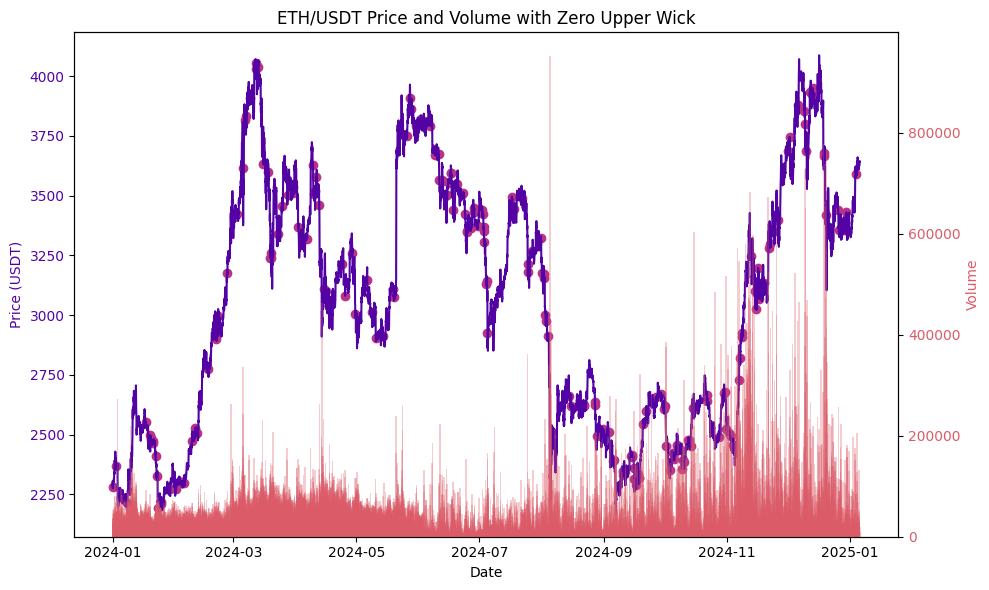

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("plasma")


# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(10,6))

# Plot the close price on the primary axis with the plasma color
ax1.plot(df_resample.index, df_resample['close'], label='Close Price', color=sns.color_palette("plasma")[0])

# Plot dots where upper wick is exactly 0 on the primary axis with the plasma color
zero_upper_wick = df_resample[df_resample['upper_wick'] == 0]
ax1.scatter(zero_upper_wick.index, zero_upper_wick['close'], color=sns.color_palette("plasma")[2], label='Zero Upper Wick', marker='o')

# Set labels for the primary axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Price (USDT)', color=sns.color_palette("plasma")[0])
ax1.tick_params(axis='y', labelcolor=sns.color_palette("plasma")[0])

# Create the secondary axis for volume
ax2 = ax1.twinx()
ax2.bar(df_resample.index, df_resample['volume'], alpha=0.3, color=sns.color_palette("plasma")[3], label='Volume')

# Set labels for the secondary axis
ax2.set_ylabel('Volume', color=sns.color_palette("plasma")[3])
ax2.tick_params(axis='y', labelcolor=sns.color_palette("plasma")[3])

# Add a title and legend
plt.title('ETH/USDT Price and Volume with Zero Upper Wick')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
fig.tight_layout()
plt.show()